# KOIOS
* Detecting the heart rate of a patient using signal processing and machine learning
* Project number: 87
* By Perry Tubul 205874290 and Eyal Golan 204229223

# Table of Contents
1. [Advanced engine implementation](#Advanced)
2. [Setup](#Setup)
3. [HR detection](#HR)
4. [Wavelet based Multivariate De-noising](#DWT)
5. [Conclusions](#conclusions)

# <a class="anchor" id="Advanced">1. Advanced engine implementation</a>
Using a similar logic as the basic engine, with the following changes for better results:
* Wavelet based Multivariate De-noising -
* MTCNN neural network - in order to detect the regions of intrest of a moving patient
* luminance detection and manipulation for more accurate heart rate results - used mainly when there are changing or bad
 lightning conditions

# <a class="anchor" id="Setup">2. Setup</a>
#### Initializing the Logger and the MTCNN neural networks, reading the videos location and detecting the OS

In [1]:
from facenet_pytorch import MTCNN #for detecting ROI of a moving subject
import torch
import face_recognition, PIL.Image, PIL.ImageDraw,math
import logging
import cv2
import platform
import scipy.signal as sig
import os

FORMAT = '[%(asctime)s] [%(levelname)s] [%(funcName)s] [%(lineno)d] : %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

with open("input_path.txt") as input_file:
    input_location = input_file.read()
pattern = ".avi"
video_sources = []

for path, subdirs, files in os.walk(input_location):
    for name in files:
        if name.endswith(pattern):
            video_sources.append(os.path.join(path, name))

print(video_sources)
logging.info("Starting ...")
if platform.system() == "Windows":
    seperator = "\\"
else:
    seperator = "/"


# since MTCNN is a collection of neural nets and other code, the device must be passed
# in the following way to enable copying of objects when needed internally
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)


[2021-07-31 13:36:27,405] [INFO] [<module>] [24] : Starting ...


['C:\\Users\\eyalg\\Downloads\\dataset\\subject2\\vid.avi', 'C:\\Users\\eyalg\\Downloads\\dataset\\subject4\\vid.avi']


## running evm pre-processing

In [2]:
#%run ./evm_preprocessing.ipynb
# video_location = dataset_location + specific_dir + seperator + "out.avi"
#video_location="out2.avi"

#### Detecting the face landmarks and parsing the ROI

In [3]:
def detect_face(frame):
    face_locations_handle_motion = mtcnn.detect(frame)
    face_location = list()
    face_location.append(float(face_locations_handle_motion[0][0][1]))
    face_location.append(float(face_locations_handle_motion[0][0][2]))
    face_location.append(float(face_locations_handle_motion[0][0][3]))
    face_location.append(float(face_locations_handle_motion[0][0][0]))
    face_locations = list()
    face_locations.append(face_location)
    return face_locations

def parse_roi(frame):
    # image = face_recognition.load_image_file(frame) # read image.
    face_locations = face_recognition.face_locations(frame,model = 'hog') # detects all the faces in image
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    try:
        face_locations = detect_face(frame)
    except Exception as e:
        logging.error("Failure in face detection, error: " + str(e))
        
    # iterate through all the faces.
    for face_location in face_locations:
        img = PIL.Image.fromarray(frame)
        top,right,bottom,left = face_location # extract all face square points.
        diff = math.floor((top - bottom) * 0.15) # 20 percent of the face len (toadd eyebrow top point).
        
        # finding the forehead
        try:
            right_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['right_eyebrow']) # right eyebrow points.
        except Exception as e:
            logging.warning("No forehead found, " + str(e))
            return None
        right_eyebrow_landmarks.sort(axis=0)
        rightest_point = right_eyebrow_landmarks[-1] # The most right point of the ROI(according to x).
        top_right_eyebrow = right_eyebrow_landmarks.min(axis = 0)[1]
        try:
            left_eyebrow_landmarks = np.asarray(face_landmarks_list[0]['left_eyebrow'])
        except Exception as e:
            logging.warning("No left eyebrow found, " + str(e))
            return None
        left_eyebrow_landmarks.sort(axis=0)
        leftest_point = left_eyebrow_landmarks[0] # the most left point of ROI.(according to x)
        top_left_eyebrow = left_eyebrow_landmarks.min(axis = 0)[1]
        bottom = min(top_right_eyebrow,top_left_eyebrow).item(0) # bottom point of the forehead.
        bottom = bottom - (0.05 * bottom) # improve bottom location by 2 percent.
        forehead = img.crop((leftest_point[0], leftest_point[1]+diff, rightest_point[0],bottom+10)) # adding diff to top to make the forehead bigger.

        # finding the second ROI:
        try:
            upper_mouth = np.asarray(face_landmarks_list[0]['top_lip']) # top_lip landmarks
        except Exception as e:
            logging.warning("No upper mouth found, " + str(e))
            return None
        upper_mouth_min = upper_mouth.min(axis = 0)[1] # The  top - lip upper point.
        try:
            upper_nose = np.asarray(face_landmarks_list[0]['nose_bridge'])
        except Exception as e:
            logging.warning("No upper nose found, " + str(e))
            return None
        upper_nose_min = upper_nose.min(axis = 0)[1]  # noise bridge upper point.
        upper_nose_min += upper_mouth_min * 0.1 # improving the noise bridge upper point.
        nose_to_upper_lip = img.crop((leftest_point[0], upper_nose_min, rightest_point[0], upper_mouth_min))

        return forehead, nose_to_upper_lip
    return None # in case of which no face was detected

### Check for bad frames
##### R > 95 and G > 40 and B > 20 and R > G and R > B
##### Based on https://arxiv.org/ftp/arxiv/papers/1708/1708.02694.pdf page 5

In [4]:
red_min_val = 95
green_min_val = 40
blue_min_val = 20
red_green_max_diff = 15
def good_frame(blue, green, red):
    if red <= red_min_val:
        logging.warning("bad frame detected, reason: red > red_min_val")
        return False
    if green <= green_min_val:
        logging.warning("bad frame detected, reason: green > green_min_val")
        return False
    if blue <= blue_min_val:
        logging.warning("bad frame detected, reason: blue > blue_min_val")
        return False
    if red <= green:
        logging.warning("bad frame detected, reason: red > green")
        return False
    if red <= blue:
        logging.warning("bad frame detected, reason: red > blue")
        return False
    if abs(red - green) <= red_green_max_diff:
        logging.warning("bad frame detected, reason: abs(red - green) > red_green_max_diff")
        return False

    return True

In [5]:
def get_new_frame(vidcap):
    success, next_image = vidcap.read()
    return success, next_image

#### Plotting RGB arrays results

In [6]:
def plot_result(greens, reds, blues, x_value, title=""):
    logging.info("Plotting results ..." + title)
    plt.figure(figsize=(6, 5))
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.subplot(3, 1, 1)
    plt.plot(x_value, greens, color="green")
    plt.subplot(3, 1, 2)
    plt.plot(x_value, reds, color="red")
    plt.subplot(3, 1, 3)
    plt.plot(x_value, blues, color="blue")
    plt.show()
    logging.info("Showing result")

#### Filtering:

In [7]:
def filter_channel(channel,fs):
    """
    This method apply filter on a channel between 0.75HZ to 4HZ.
    :param channel: Is a signal to apply the filter to.
    :param fs: Is the sampling rate of channel.
    :return: The filtered channel.
    """
    bh, ah = sig.butter(4, 0.75 / (fs / 2), 'highpass')
    bl, al = sig.butter(4, 4 / (fs / 2), 'lowpass')
    try:
        channel = sig.filtfilt(bh, ah, channel) # applying the filter coefficient on the sig
    except:
        return None
    #channel = np.absolute(channel)
    channel_after_filter = sig.filtfilt(bl, al, channel) # applying the filter coefficient on the sig
    return channel_after_filter

#### Getting RGB values from a frame and adding them to arrays

In [8]:
def parse_luminace(red, green, blue):
    luminance_level = 0.2126 * red + 0.7152 * green + 0.0722 * blue
    return luminance_level
def parse_RGB(rois, color_sig):
    """
    Parses an image to its RGB channels
    :param image: the image to be parsed
    :param vidcap:
    :param greens: array containing green channel values
    :param blues: array containing blue channel values
    :param reds: array containing red channel values
    :param frame_number - is the number of the frame of the video.
    :return: a flag indicating if there is a next image, and the next image
    """
    
    for i,r in enumerate(rois):
        try:
            new_red = r.getchannel(0)
        except Exception as e: 
            print(e)
        new_green = r.getchannel(1)
        new_blue = r.getchannel(2)
        b_mean,g_mean,r_mean = np.mean(new_blue),np.mean(new_green),np.mean(new_red)
        luminance_level = parse_luminace(r_mean, g_mean, b_mean)
        if good_frame(b_mean,g_mean,r_mean):
            #color_channels = r.reshape(-1, r.shape[-1])
            #avg_color = color_channels.mean(axis=0)
            color_sig[i].append(g_mean)
    return True, color_sig, luminance_level

In [9]:
def log_video_details(video_source):
    logging.info("\nInformation on video:\t\t\t\t\t\t" + str(video_source) +
                 "\nFPS:\t\t\t\t\t\t" + str(fps) + 
                 "\nRound FPS:\t\t\t\t\t\t" + str(round_fps) + 
                 "\nNumber of frames:\t\t\t\t" + str(number_of_frames) + 
                 "\nNumber of bad frames:\t\t\t\t" + str(bad_frames) + 
                 "\nMax luminanace:\t\t\t\t\t" + str(max_luminance) + 
                 "\nMin luminanace:\t\t\t\t\t" + str(min_luminance) +
                 "\nMax diff of luminanace between adjacent frames:\t" + str(max_diff_luminance_adjacent) +
                 "\nAvg luminanace:\t\t\t\t\t" + str(avg_luminance))

In [10]:
import pandas as pd
def indexes(y, thres=0.3, min_dist=1, thres_abs=False):
    if isinstance(y, np.ndarray) and np.issubdtype(y.dtype, np.unsignedinteger):
        raise ValueError("y must be signed")

    if not thres_abs:
        thres = thres * (np.max(y) - np.min(y)) + np.min(y)

    min_dist = int(min_dist)

    # compute first order difference
    dy = np.diff(y)

    # propagate left and right values successively to fill all plateau pixels (0-value)
    zeros, = np.where(dy == 0)

    # check if the signal is totally flat
    if len(zeros) == len(y) - 1:
        return np.array([])

    if len(zeros):
        # compute first order difference of zero indexes
        zeros_diff = np.diff(zeros)
        # check when zeros are not chained together
        zeros_diff_not_one, = np.add(np.where(zeros_diff != 1), 1)
        # make an array of the chained zero indexes
        zero_plateaus = np.split(zeros, zeros_diff_not_one)

        # fix if leftmost value in dy is zero
        if zero_plateaus[0][0] == 0:
            dy[zero_plateaus[0]] = dy[zero_plateaus[0][-1] + 1]
            zero_plateaus.pop(0)

        # fix if rightmost value of dy is zero
        if len(zero_plateaus) and zero_plateaus[-1][-1] == len(dy) - 1:
            dy[zero_plateaus[-1]] = dy[zero_plateaus[-1][0] - 1]
            zero_plateaus.pop(-1)

        # for each chain of zero indexes
        for plateau in zero_plateaus:
            median = np.median(plateau)
            # set leftmost values to leftmost non zero values
            dy[plateau[plateau < median]] = dy[plateau[0] - 1]
            # set rightmost and middle values to rightmost non zero values
            dy[plateau[plateau >= median]] = dy[plateau[-1] + 1]

    # find the peaks by using the first order difference
    peaks = np.where(
        (np.hstack([dy, 0.0]) < 0.0)
        & (np.hstack([0.0, dy]) > 0.0)
        & (np.greater(y, thres))
    )[0]

    # handle multiple peaks, respecting the minimum distance
    if peaks.size > 1 and min_dist > 1:
        highest = peaks[np.argsort(y[peaks])][::-1]
        rem = np.ones(y.size, dtype=bool)
        rem[peaks] = False

        for peak in highest:
            if not rem[peak]:
                sl = slice(max(0, peak - min_dist), peak + min_dist + 1)
                rem[sl] = True
                rem[peak] = False

        peaks = np.arange(y.size)[~rem]

    return peaks

def print_results(window_sig, window, xlabel, ylabel, change_range, title):
    fig = plt.figure()
    fig.suptitle(title)
    ax = fig.subplots()
    while len(window_sig) > len(window):
        window_sig = window_sig[:-1]
    ax.plot(window_sig,window,color ='green')
    if change_range:
        plt.xlim([0, 5])

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xscale('linear')
    ax.spines['bottom'].set_color('red')
    ax.spines['left'].set_color('red')
    ax.xaxis.label.set_color('red')
    ax.yaxis.label.set_color('red')
    ax.tick_params(axis='x', colors='red')
    ax.tick_params(axis='y', colors='red')
    plt.show()

import scipy
def find_peaks_with_scipy(window_sig, window, round_fps, hr):
    while len(window_sig) > len(window):
        window_sig = window_sig[:-1]
    peaks, _ = scipy.signal.find_peaks(window, distance=round_fps)
    plt.plot(window_sig,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.title("Peaks with scipy")
    plt.show()
    logging.info("Peaks vector with scipy: " + str(peaks) + " num of peaks: " + str(len(peaks)))

def print_peaks(window_sig, window):
    while len(window_sig) > len(window):
        window_sig = window_sig[:-1]
        
    peaks = indexes(window,min_dist=20)
    plt.plot(window_sig,window,'-go',markerfacecolor='red',markevery=peaks)
    plt.title("Peaks with implemented function")
    plt.show()
    logging.info("Peaks vector by implemented function: " + str(window_sig[peaks]) + " num of peaks: " + str(len(window_sig[peaks])))
    #print(window_sig)
    #test_peaks = find_peaks(window_sig)
    #plt.plot(window_sig,window,'-go',markerfacecolor='red',markevery=test_peaks)
    #np.savetxt("time_of_peaks.csv", x[peaks], delimiter=",")
    
def find_hr_in_window(green, window_start, round_fps, window_id, window_size):
    
    round_fps = int(round_fps)
    if window_start + round_fps * window_size > len(green):
        window = green[window_start : ]
    else:
        window = green[window_start : window_start + round_fps * window_size]
    window_sig = np.arange(window.size/round_fps,step= (1/round_fps))
    
    print_results(window_sig, window, 'X-axis', 'Y-axis', False, "Green signal")

    window = window - np.mean(window)
    window = window / np.std(window)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False, "Green signal normalized")
    
    g = filter_channel(window,round_fps)
    if g is None:
        return
    from skimage.restoration import denoise_wavelet
    #g = denoise_wavelet(g,wavelet='sym2',wavelet_levels = 4)
    print_peaks(window_sig, g)
    print_results(window_sig, window, 'X-axis', 'Y-axis', False, "")

    f, Pxx_den = sig.periodogram(g, round_fps)
    
    print_results(f, Pxx_den, 'Frequency [Hz]', 'PSD [V**2/Hz]', True, "PSD by Frequency")
    # plt.semilogy(f, Pxx_den)
    # plt.ylim([1e-7, 1e2])
    # plt.xlabel('frequency [Hz]')
    # plt.ylabel('PSD [V**2/Hz]')
    # plt.show()


    max_val = Pxx_den.argmax()
    logging.info("Window " + str(window_id) +
                 ":\nHighest freq:" + str(f[max_val]) + "\nHeart rate: " + str(f[max_val]*60))
    
    find_peaks_with_scipy(window_sig, g,round_fps, f[max_val]*60)

# <a class="anchor" id="DWT">4. Wavelet based Multivariate De-noising</a>
* The de-noising of the multivariate signal is performed by removing the noise elements ε by
thresholding the noisy signals
* The heart beat is shifted to a frequency with lower power in the power spectral distribution (PSD).
* We estimated the heart rate by exploiting the periodicity of the PPG signal by a frequency based voting scheme

In [11]:
import pywt
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet as MCD
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import numpy as np
import scipy
import sys
np.set_printoptions(threshold=sys.maxsize)
def eigenvalue_decomposition(mat):
        """ return (diagonal,orthogonal matrix)
        """
        """
        """
        # eigen_vals, eigen_vectors
        eigen_vals, eigen_vectors = np.linalg.eigh(mat)
        d = np.diag(eigen_vals)
        return d,eigen_vectors

    
def multivariate_video_signal(signal):
    """
    Algorithm 1
    :param signal: is a 2D signal. One dimension the signal from the forehead, and second is from above the upper lip
    :return: multivariate PPG 
    """    
    sig1 = signal[0,:].T
    sig2 = signal[1,:].T
    n = len(sig1)
    wavelet = pywt.Wavelet('sym2') 
    c = pywt.wavedec(np.column_stack((sig1,sig2)),wavelet,level = 4,axis = 0)
    mcd = MCD(random_state = 0).fit(c[-1]).covariance_
    V,D,VT = np.linalg.svd(mcd)

    lst = []
    pca = PCA(1)
    comp = StandardScaler().fit_transform(c[0]) # normalize
    c[0] = comp
    comp = pca.fit_transform(comp)
    comp = np.column_stack((comp,comp))
    lst.append(comp)
    # Basis change 
    for i in range (1,len(c)):
        x_i = np.dot(c[i],V)
        gama_0 = np.sqrt(2*np.log(n)*D[0])
        xi_0 = pywt.threshold(x_i[:,0],value= gama_0,mode='soft')
        gama_1 = np.sqrt(2*np.log(n)*D[1])
        xi_1 = pywt.threshold(x_i[:,1],value= gama_1,mode='soft')
        xi = np.column_stack((xi_0,xi_1))
        xi = xi@VT
        lst.append(xi)
    return pywt.waverec(lst,wavelet,axis = 0)

def mvd(color_sig):
    ppg_hat = multivariate_video_signal(color_sig)
    return ppg_hat


In [12]:
def detect_hr(video_source):
    logging.info("\n=======================\n" + video_source + "\n=======================\n")
    color_sig_array = np.asarray(color_sig)
    plt.figure(figsize=(15,6))
    plt.subplot(2,1,1)
    plt.plot(color_sig_array[0],"green")
    sig_mvd = mvd(color_sig_array) # n X 2
    ppg_hat_zero = filter_channel(sig_mvd[:,0].T,round_fps)
    ppg_hat_one = filter_channel(sig_mvd[:,1].T,round_fps)
    ppg_hat = np.vstack((ppg_hat_zero,ppg_hat_one))
    plt.subplot(2,1,2)
    
    green = ppg_hat[0]
    plt.plot(green,"red")

    window_start = 0
    window_size = 30
    window_id = 0
    limit = good_frame_number - int(round_fps) * window_size
    while window_start < limit :
        find_hr_in_window(green, window_start, round_fps, window_id, window_size)
        window_start += int(round_fps) * window_size
        window_id += 1
    if window_start < good_frame_number:
        find_hr_in_window(green, window_start, round_fps, window_id, good_frame_number - window_start)

# <a class="anchor" id="HR">3. HR detection</a>
#### Main loop - going over all the frames of the video

[2021-07-31 13:36:28,186] [INFO] [<module>] [8] : Working on video C:\Users\eyalg\Downloads\dataset\subject2\vid.avi
[2021-07-31 13:36:28,192] [INFO] [<module>] [14] : Parsing images ...
[2021-07-31 13:36:28,194] [INFO] [<module>] [25] : Parsing frame 0/1989.0
C:\Users\eyalg\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
[2021-07-31 13:37:06,476] [INFO] [<module>] [25] : Parsing frame 100/1989.0
[2021-07-31 13:37:47,672] [INFO] [<module>] [25] : Parsing frame 200/1989.0
[2021-07-31 13:38:30,457] [INFO] [<module>] [25] : Parsing frame 300/1989.0
[2021-07-31 13:39:13,681] [INFO] [<module>] [25] : Parsing frame 400/1989.0
[202

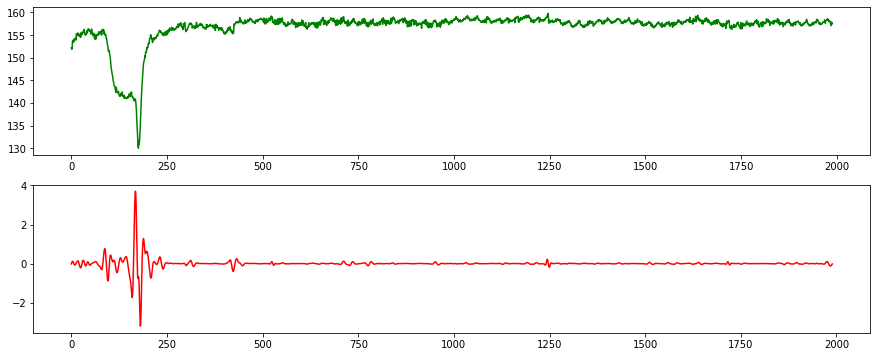

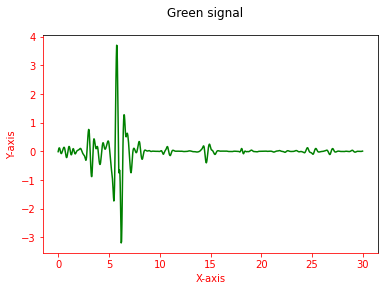

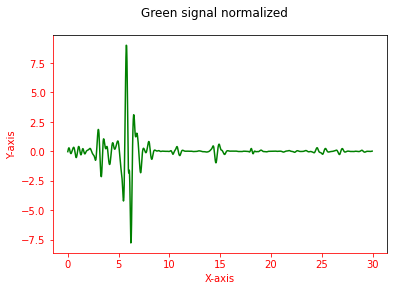

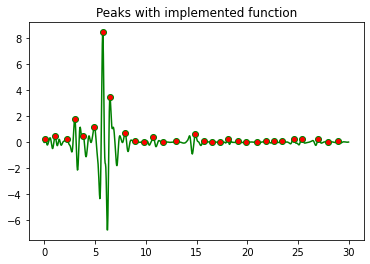

[2021-07-31 13:51:15,726] [INFO] [print_peaks] [109] : Peaks vector by implemented function: [ 0.10344828  1.06896552  2.20689655  3.          3.82758621  4.93103448
  5.75862069  6.48275862  7.96551724  8.93103448  9.82758621 10.75862069
 11.68965517 12.96551724 14.89655172 15.72413793 16.55172414 17.31034483
 18.06896552 19.03448276 19.82758621 20.93103448 21.79310345 22.5862069
 23.44827586 24.55172414 25.34482759 27.         27.96551724 28.96551724] num of peaks: 30


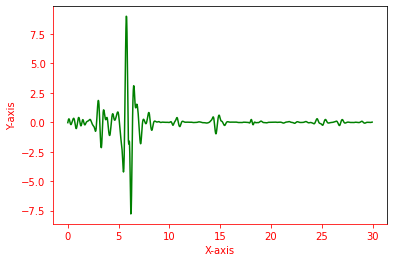

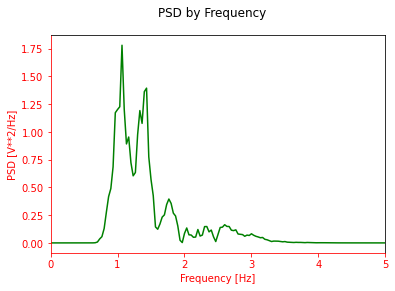

[2021-07-31 13:51:15,853] [INFO] [find_hr_in_window] [149] : Window 0:
Highest freq:1.0666666666666667
Heart rate: 64.0


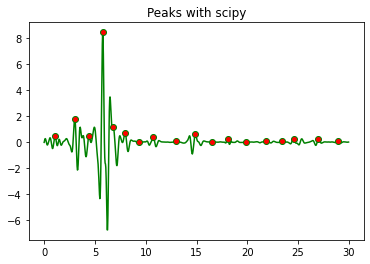

[2021-07-31 13:51:15,919] [INFO] [find_peaks_with_scipy] [99] : Peaks vector with scipy: [ 31  87 128 167 197 231 271 312 376 432 480 524 575 632 680 712 783 840] num of peaks: 18


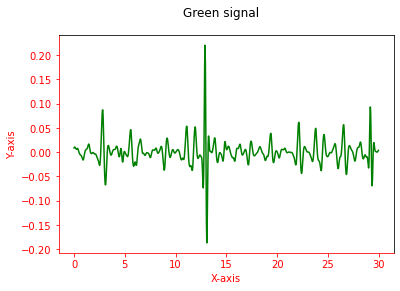

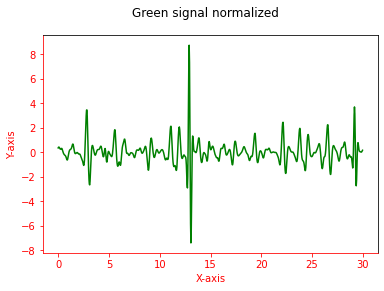

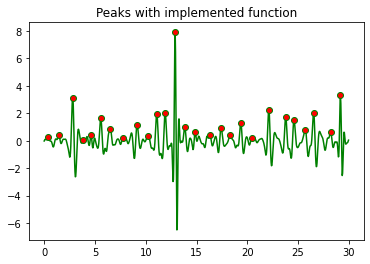

[2021-07-31 13:51:16,189] [INFO] [print_peaks] [109] : Peaks vector by implemented function: [ 0.37931034  1.44827586  2.79310345  3.86206897  4.62068966  5.5862069
  6.51724138  7.75862069  9.13793103 10.24137931 11.10344828 11.93103448
 12.89655172 13.86206897 14.86206897 16.31034483 17.4137931  18.31034483
 19.37931034 20.44827586 22.10344828 23.79310345 24.5862069  25.68965517
 26.51724138 28.20689655 29.17241379] num of peaks: 27


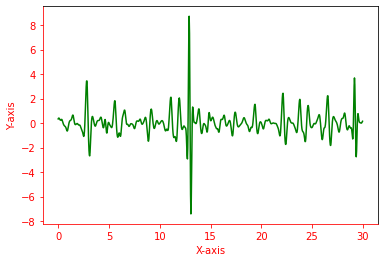

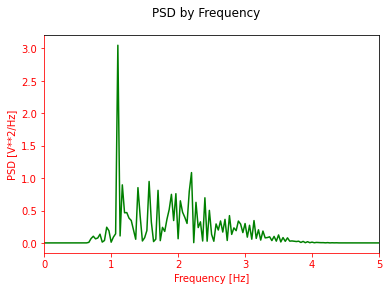

[2021-07-31 13:51:16,321] [INFO] [find_hr_in_window] [149] : Window 1:
Highest freq:1.1
Heart rate: 66.0


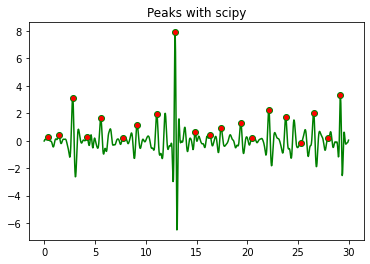

[2021-07-31 13:51:16,384] [INFO] [find_peaks_with_scipy] [99] : Peaks vector with scipy: [ 11  42  81 122 162 225 265 322 374 431 473 505 562 593 641 690 732 769
 810 846] num of peaks: 20


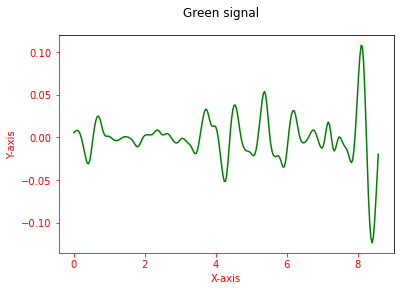

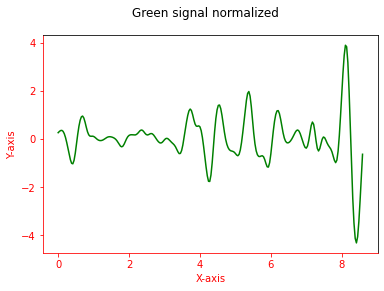

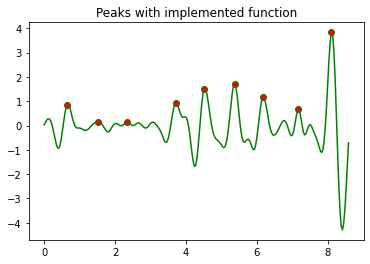

[2021-07-31 13:51:16,581] [INFO] [print_peaks] [109] : Peaks vector by implemented function: [0.65517241 1.51724138 2.34482759 3.72413793 4.51724138 5.37931034
 6.17241379 7.17241379 8.10344828] num of peaks: 9


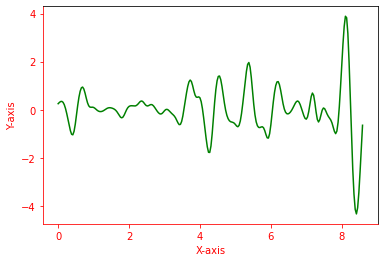

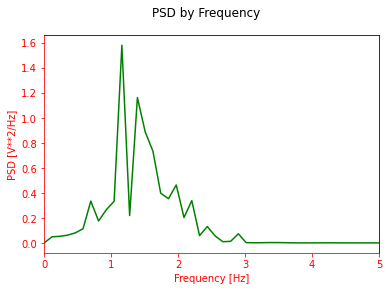

[2021-07-31 13:51:16,719] [INFO] [find_hr_in_window] [149] : Window 2:
Highest freq:1.1600000000000001
Heart rate: 69.60000000000001


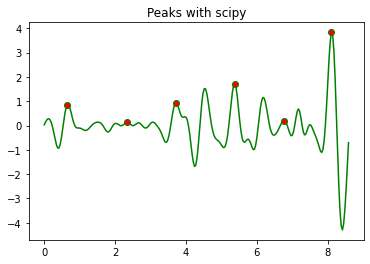

[2021-07-31 13:51:16,787] [INFO] [find_peaks_with_scipy] [99] : Peaks vector with scipy: [ 19  68 108 156 196 235] num of peaks: 6
[2021-07-31 13:51:16,787] [INFO] [<module>] [8] : Working on video C:\Users\eyalg\Downloads\dataset\subject4\vid.avi
[2021-07-31 13:51:16,795] [INFO] [<module>] [14] : Parsing images ...
[2021-07-31 13:51:16,795] [INFO] [<module>] [25] : Parsing frame 0/2028.0
[2021-07-31 13:52:07,109] [INFO] [<module>] [25] : Parsing frame 100/2028.0


In [ ]:
# Parsing video:
for video_location in video_sources:
    color_sig = [[],[]]
    heart_rates = []
    good_frame_number = 0
#     total_frame_number = 180
    total_frame_number = 0
    logging.info("Working on video " + video_location)
    vidcap = cv2.VideoCapture(video_location)
    success, image = vidcap.read()
    fps = vidcap.get(cv2.CAP_PROP_FPS) # fs == sampling rate
    round_fps = np.round(fps)
    number_of_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    logging.info("Parsing images ...")
    skipped_frames = 0
    bad_frames = 0
    max_luminance = 0
    min_luminance = 200
    avg_luminance = 0
    perv_luminance = None
    max_diff_luminance_adjacent = 0

    while success:
        if total_frame_number % 100 == 0:
            logging.info("Parsing frame " + str(total_frame_number) + "/" + str(number_of_frames))
        rois = parse_roi(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # build image ROI (rois is a tuple contains two regions)
        if rois is not None :
            #roi = np.vstack((rois[0], rois[1]))
            try:
                is_good_frame,color_sig, luminance_level = parse_RGB(rois, color_sig)
                if perv_luminance is not None and luminance_level - perv_luminance > max_diff_luminance_adjacent:
                    max_diff_luminance_adjacent = luminance_level - perv_luminance
                if luminance_level > max_luminance:
                    max_luminance = luminance_level
                if luminance_level < min_luminance:
                    min_luminance = luminance_level
                avg_luminance += luminance_level
                perv_luminance = luminance_level
            except Exception as e:
                logging.error("failed to get output from parse_RGB!\nError:" + str(e))
                is_good_frame = False
                bad_frames += 1
            if is_good_frame:
                good_frame_number += 1
                #logging.info("luminance level: " + str(luminance_level))
        if rois is None:
            bad_frames += 1
        total_frame_number += 1
        success, image = get_new_frame(vidcap)
    avg_luminance /= total_frame_number
    log_video_details(video_location)
    try:
        detect_hr(video_location)
    except Exception as e:
        logging.warning("Issue in detecting hr in video: " + str(e))